[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zhimingkuang/Harvard-AM-115/blob/main/05_model_fitting/fit_yeast_ode.ipynb)

## This code fits the yeast data to the logistic equation

It gives an example of how to read in the csv data and provides a template for the exercise of modeling running.

>Run the following cell on Colab to fix the version issue of xlrd (default is 1.1.0, and pandas needs at least 1.2.0)

In [20]:
# If running locally, you may need to install the following packages
# Uncomment any needed and run this block (change pip3 with conda if you use Anaconda)

# !pip3 install numpy
# !pip3 install pandas
!pip3 install xlrd
# !pip3 install matplotlib
# !pip3 install scipy
# !pip3 install statsmodels


[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 30.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 8.9 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
# if you have already installed a previous version of xlrd
!pip install --upgrade --force-reinstall xlrd

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.stats import chisquare

### Load data

>If working within Google Colab, run the following cell to clone the Github repo to access the data. If not can just skip to the next cell.

In [ ]:
# Load in data if run on Google Colab
!git clone https://github.com/zhimingkuang/Harvard-AM-115.git
%cd Harvard-AM-115/05_model_fitting

In [7]:
# Data import and setup
# Give the location of the file, replace with yours
loc = ('carlson_yeast_data.xls')

# Read in the data from the Carlson 1913 paper
# Read in Excel, set up Series
yeast_data = pd.read_excel(loc, index_col=None)

# For simplicity, we shall assume the initial yeast amount is precisely
# known (it is hard-coded in ode45_logistic as the initial condition).
# Therefore, the actual data to be fitted are the second point and beyond.

# Separate time and amount into separate Series
# Make sure to start at hours = 1 for the data fitting
time = yeast_data.iloc[1:,0]
amount = yeast_data.iloc[1:,1]

# Initial guess of the parameters r and K
# We have normalized the parameters so they are of order 1
beta0 = [1,1]

In [8]:
# Define the ODE to be solved
def f(t, y, r, K):
    """Define the logistic differential equation

    Args:
        t (float): time
        y (numpy.ndarray): population
        r (numpy.float64): growth rate
        K (numpy.int64): carrying capacity

    Returns:
        numpy.ndarray: differential equation
        
    """
    
    ydot = r*y*(1-y/K)
    
    return ydot

In [9]:
# Define the curve to be fitted as a function of parameters and indepenent variable
def ode45_logistic(t, beta0, beta1):
    """Define the logistic differential equation

    Args:
        t (numpy.ndarray): time
        beta0 (numpy.int64): first unknown parameter, growth rate
        beta1 (numpy.int64): second unknown parameter, carrying capcity

    Returns:
        numpy.ndarray: y-values after data fitting
        
    """
    
    # Unpack parameters
    y0 = 9.6 # initial yeast population, assumed to be known to simplify the plots
    r = beta0*0.5 # growth rate, normalized so beta is of order 1
    K = beta1*600 # carrying capacity, normalized so beta is of order 1
    t0 = 0 # initial time     
    
    # Solve the logistic ODE with RK45
    sol = solve_ivp(lambda t,y: f(t,y,r,K), [t0,max(t)], [y0], rtol=1e-10)
    # Unpack solution
    t, y = sol.t, sol.y
    
    # Do the interpolation, which creates a function yfit
    yfit = interp1d(t,y[0,:])
    y_new = yfit(time)
    
    return y_new

### Nonlinear curve fit

Reference: https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares

In [10]:
def residuals(coeffs, y, t):
    """Define the function which computes the vector of residuals

    Args:
        coeffs (numpy.ndarray): coefficients beta0 and beta1
        y (pandas.core.series.Series): yeast amount
        t (pandas.core.series.Series): time

    Returns:
        pandas.core.series.Series: residue
        
    """
    
    return y-ode45_logistic(t,coeffs[0],coeffs[1])

In [11]:
nlinfit = least_squares(residuals, beta0, args=(amount,time), method='lm')
beta = nlinfit.x # beta is the estimated optimal values for the parameters
J = nlinfit.jac # J is the Jacobian at the optimal point
# Find the predicted values given the best-fit beta parameters
yfit = ode45_logistic(time, beta[0], beta[1])

In [12]:
print(f"Estimated beta parameters\n beta0: {beta[0]}\n beta1: {beta[1]}")

Estimated beta parameters
 beta0: 1.0810096398406785
 beta1: 1.106748790289377


In [13]:
# Compute the residue
residue = amount - ode45_logistic(time, *beta)
# Compute the mean squared error
MSE = residue.T@residue / (time.size-2)
# Compute the covariance matrix for the parameters
CovB = np.linalg.inv(J.T.dot(J)) # CovB is the covariance matrix for the parameters

>Note: Different from MATLAB `nlinfit`, we do not have residue, MSE and Jacobian as returns; need to calculate them separately. Also depends on which library functions we use, the return values can also vary, _e.g._ `CovB` values, the input functions can also be different. There are essentially three library functions to do nonlinear fit: `curve_fit`, `least_squares`, and `leastsq`.
>
>`leastsq` uses the Levenberg–Marquardt algorithm only for nonlinear fit
>
>`curve_fit` is essentially a wrapper of `leastsq`: https://stats.stackexchange.com/questions/464679/difference-between-scipy-optimize-least-squares-and-scipy-optimize-curve-fit
>
>`least_squares` is a newer implementation to do nonlinear fit with other algorithms, `leastsq` is legacy code: https://stackoverflow.com/questions/41315270/scipy-leastsq-vs-least-squares

In [14]:
# Compare the covariance matrix with different library functions
from scipy.optimize import leastsq
from scipy.optimize import curve_fit

# Use leastsq
nlinfit_leastsq = leastsq(residuals, beta0, args=(amount,time), full_output=True)
CovB_leastsq = nlinfit_leastsq[1]
# Use curve_fit
nlinfit_curve_fit = curve_fit(ode45_logistic, time, amount, p0=beta0, method='lm') # notice the func is different!
CovB_curve_fit = nlinfit_curve_fit[1]

print('leastsq CovB is\n',CovB_leastsq)
print('curve_fit CovB is\n',CovB_curve_fit)
print('least_squares CovB is\n',CovB)

leastsq CovB is
 [[ 6.19462737e-07 -3.02053240e-07]
 [-3.02053240e-07  5.26871080e-07]]
curve_fit CovB is
 [[ 8.44751019e-06 -4.11904974e-06]
 [-4.11904974e-06  7.18485319e-06]]
least_squares CovB is
 [[ 6.19471152e-07 -3.02055443e-07]
 [-3.02055443e-07  5.26870926e-07]]


In [15]:
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['mathtext.default'] = 'regular'
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20

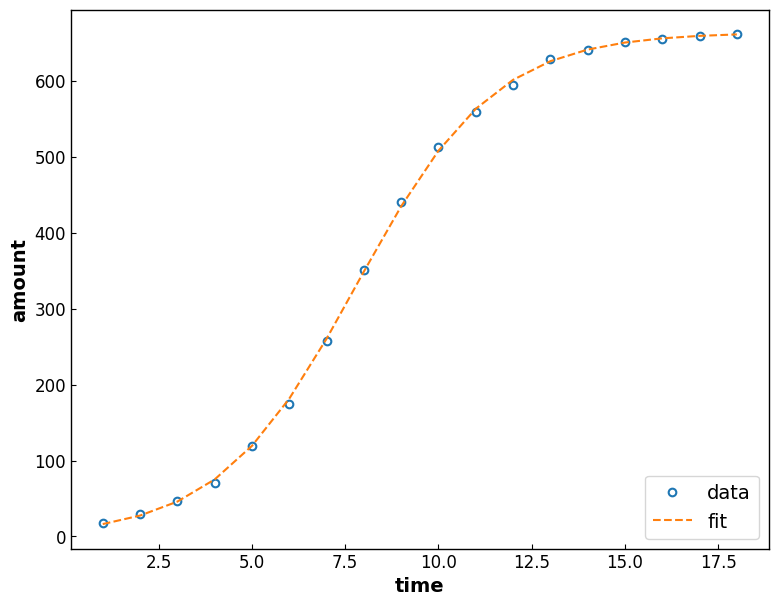

In [16]:
# Plot solution
fig, ax = plt.subplots(1,1,figsize=(9,7))

ax.plot(time, amount, 'o', linewidth=1.5, mfc='none', ms=5.5, mew=1.5, label='data')
ax.plot(time, yfit, '--', linewidth=1.5, mfc='none', ms=5.5, mew=1.5, label='fit')

# Set axes labels and legends
ax.set_xlabel('time')
ax.set_ylabel('amount')
ax.legend(loc='lower right')

plt.show()

## Our work is not done!
Need to test whether the residual is consistent with our assumptions.

### Residue analysis

First, plot the residue

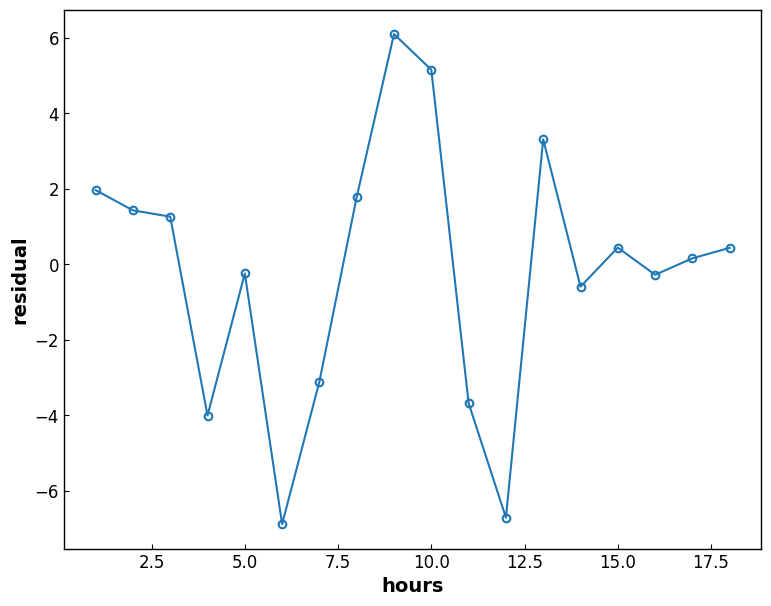

In [17]:
# Plot the residue
fig, ax = plt.subplots(1,1,figsize=(9,7))

ax.plot(time, residue, '-o', linewidth=1.5, mfc='none', ms=5.5, mew=1.5)

# Set axes labels and legends
ax.set_xlabel('hours')
ax.set_ylabel('residual')

plt.show()

Next, check autocorrelation

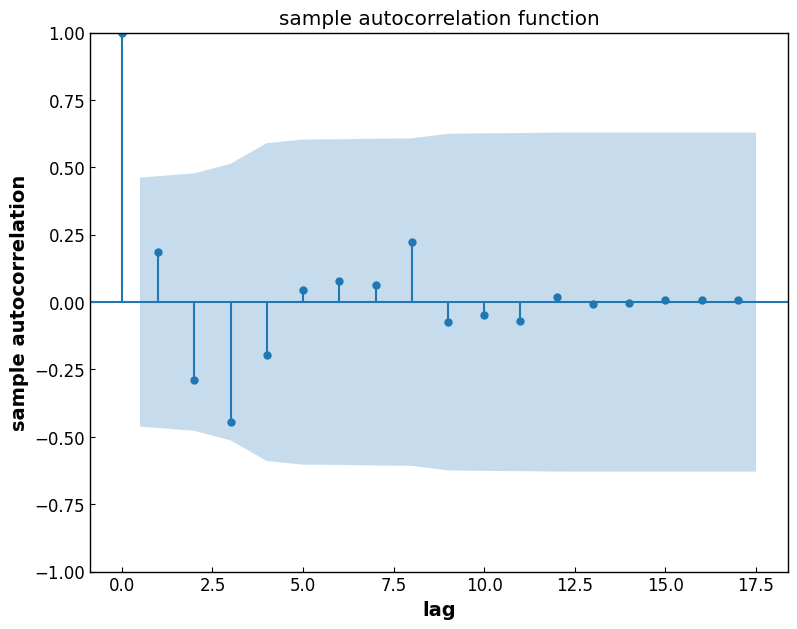

In [21]:
# https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation
fig, ax = plt.subplots(1,1,figsize=(9,7))

fig = plot_acf(residue, lags=17, ax=ax)

# Set title, axes labels and legends
ax.set_title('sample autocorrelation function')
ax.set_xlabel('lag')
ax.set_ylabel('sample autocorrelation')

plt.show()

Now, test for heteroscedasticity

In [22]:
# Use the ARCH test by R. F. Engle, which assumes no autocorrelation
# https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_arch.html
from statsmodels.stats.diagnostic import het_arch

[fARCH,pARCH] = het_arch(residue)[-2:]

print("fARCH:",fARCH)
print("pARCH:",pARCH)

fARCH: 0.44206195941467424
pARCH: 0.7276010003939459


`fARCH` is the F-statistic for the F test. A small F-statistic means we cannot reject the null hypothesis that there is no heteroscedasticity. `pARCH` is the p-value. A smaller p-value indicates greater confidence in rejecting the null hypothesis.

>Note: We use `hARCH` in MATLAB, instead of F-statistic here.

### Extra note

If the residual has significant autocorrelation or heteroscedasticity, the parameter estimates are still unbiased but the uncertainty estimates are unreliable. In this case, try generalized least squares, which accounts for the noise (or innovation) covariance matrix, which is no longer just the identity matrix multiplied by a scalar. It is however not easy to get an accurate estimate of the noise covariance.

### Now, test the assumption of normal distribution

A visual way with quantile–quantile plot.

>Note: The reference line (red) is a bit different from MATLAB.

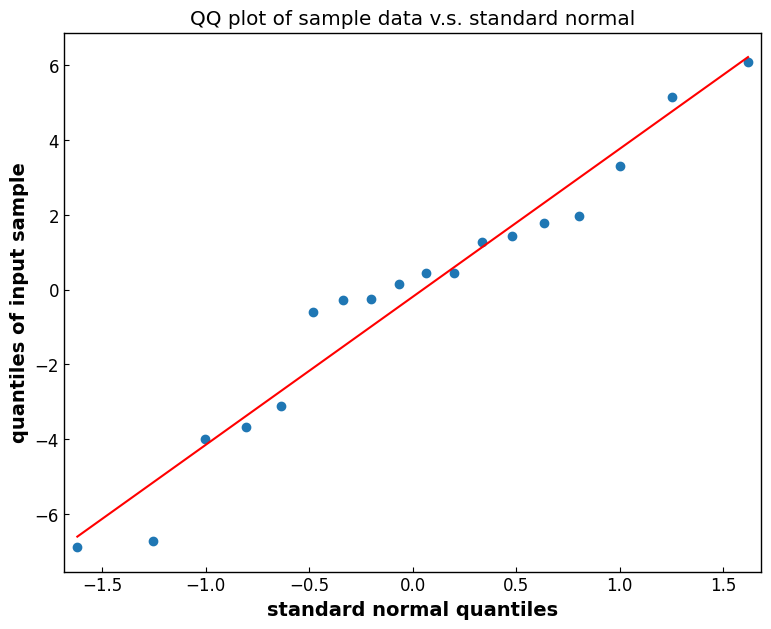

In [23]:
# https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot.html
from statsmodels.api import qqplot

# Plot the QQ plot
fig, ax = plt.subplots(1,1,figsize=(9,7))

fig = qqplot(residue, line='r', ax=ax)

# Set title, axes labels and legends
ax.set_title('QQ plot of sample data v.s. standard normal')
ax.set_xlabel('standard normal quantiles')
ax.set_ylabel('quantiles of input sample')

plt.show()

A more quantitative way with chi-square goodness of fit test.

If we know the measurement precision, we can compare MSE to the expected MSE to test the goodness of fit. While don't know the measurement precision here, we can still test if the residuals is consistent with a normal distribution with  the mean and standard deviation estimated from the residuals.

>Note: Chi-square test results are a bit different from MATLAB.

In [24]:
# Perform the chi-square goodness of fit test, using the predicted data and the actual data
# Need to normalize due to this change: https://github.com/scipy/scipy/issues/13362
import scipy.stats as stats

# Obtain the histogram (i.e. the observed frequency)
hist,bin_edge = np.histogram(residue,bins=5)
# Fit a normal distribution and compute the expected frequency for the bins
mu,std = stats.norm.fit(residue)
cdf = stats.norm.cdf(bin_edge, mu, std)
expected = len(residue) * np.diff(cdf) / (cdf[-1]-cdf[0])
# Perform chisquare test
h,p = chisquare(hist, expected)
print(f'Chi-square test statistics (h-value): {h}, p-value: {p}')

Chi-square test statistics (h-value): 0.428429730882548, p-value: 0.9800838019204977


>The null hypothesis: that the residuals are drawn from a normal distribution with the mean and standard deviation estimated from the residuals.
>
>The smaller the p-value: indicates greater confidence in rejecting the null hypothesis.

h is the chi-square statistic. A small h means we cannot reject the null hypothesis that residue is drawn from a normal distribution with the mean and standard deviation estimated from the residuals. p is the p-value. A smaller p-value indicates greater confidence in rejecting the null hypothesis.

### Extra note

Our dataset is quite small, and it is probably better to use the Lilliefors test, designed for small datasets ```[hNorm,pNorm] = lillietest(R)```

Lilliefors, H. W. _On the Kolmogorov-Smirnov test for normality with mean and variance unknown._ Journal of the American Statistical Association. Vol. 62, 1967, pp. 399–402.

### Now look at confidence intervals (95% confidence intervals)

Python implemenation of MATLAB `nlparci`.

In [25]:
# http://scipy.github.io/devdocs/reference/generated/scipy.stats.t.html
from scipy.stats.distributions import t

alpha = 0.05
dof = time.size-2 # statistical degree of freedom
tval = t.ppf(1.0-alpha/2., dof)

In [26]:
ci = np.zeros((2,2))
for i in range(2):
    ci[i,0] = beta[i] - CovB[i,i]**0.5*tval
    ci[i,1] = beta[i] + CovB[i,i]**0.5*tval

> `ci` values are slightly different from the MATLAB results. Different software packages can factor in the difference in the nonlinear fit results.

In [27]:
ci

array([[1.07934114, 1.08267814],
       [1.10521004, 1.10828754]])

Optimal values:

In [28]:
beta

array([1.08100964, 1.10674879])

### There is more to the parameter uncertainties

More information is contained in the eigenvalues and eigenvectors of the covariance matrix `CovB`.

>Note: The CovB is different from the Matlab result so the eigenvalues are different. Notice that in Python we are optimizing the residuals function (`least_squares`), not fitting the function directly (`curve_fit`), _i.e._ the two methods optimize different functions. Eigenvectors may have different sign w.r.t. MATLAB results, which is linearly equivalent and is ok.

In [29]:
eigenvalues,eigenvectors = np.linalg.eig(CovB)
print("Eigenvalues:\n",eigenvalues)
print("Eigenvectors:\n",eigenvectors)

Eigenvalues:
 [8.78754402e-07 2.67587677e-07]
Eigenvectors:
 [[ 0.75878648  0.65133945]
 [-0.65133945  0.75878648]]


In [30]:
# Code to visualize the errors
b1 = np.arange(0.99, 1.01, 0.001)
b2 = np.arange(0.99, 1.01, 0.001)
B1,B2 = np.meshgrid(b1,b2)
rmse = np.zeros((len(b1),len(b2)))

for i in range(len(b1)):
    for j in range(len(b2)):
        rmse[i,j]=np.linalg.norm(amount-ode45_logistic(time,beta[0]*B1[i,j],beta[1]*B2[i,j]))

normalized_mse = np.power(rmse,2) / MSE / (time.size-2)
# time.size-2 is the number of data points minus the number of parameters

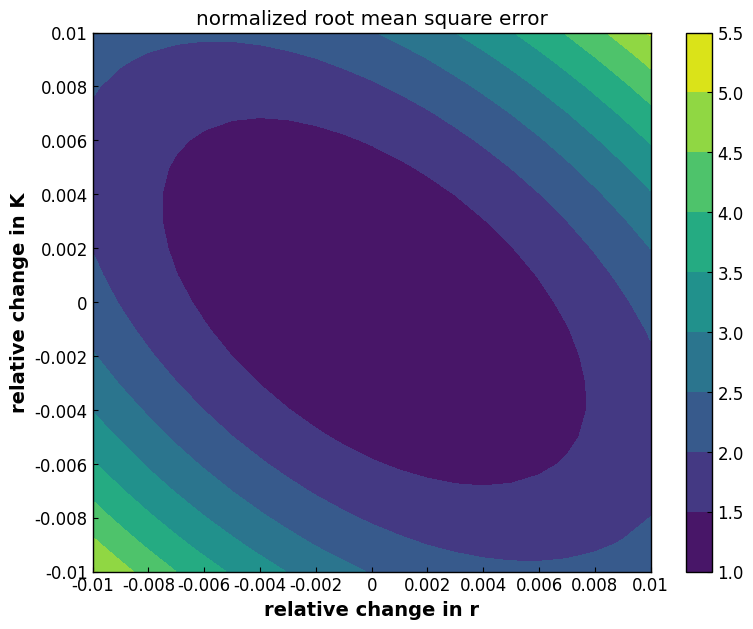

In [31]:
# Plot error
fig, ax = plt.subplots(1,1,figsize=(9,7))

img = ax.contourf(B1-1., B2-1., normalized_mse, 9)

# Set colorbar
cbar = fig.colorbar(img, ax=ax)

# Set xticks and yticks to match MATLAB results
ticks = [-0.01, -0.008, -0.006, -0.004, -0.002, 0, 0.002, 0.004, 0.006, 0.008, 0.01]
ax.set_xticks(ticks) 
ax.set_xticklabels(ticks)
ax.set_yticks(ticks) 
ax.set_yticklabels(ticks)

# Set title and axes labels
ax.set_title('normalized root mean square error')
ax.set_xlabel('relative change in r')
ax.set_ylabel('relative change in K')

plt.show()

### The Jacobian describes how the parameters affect data

which linearized around the optimal values. In this case, we can reason a priori that noise shouldn't be corrected with the effect of r or K on the yeast population, but we can nontheless confirm that this is indeed the case.

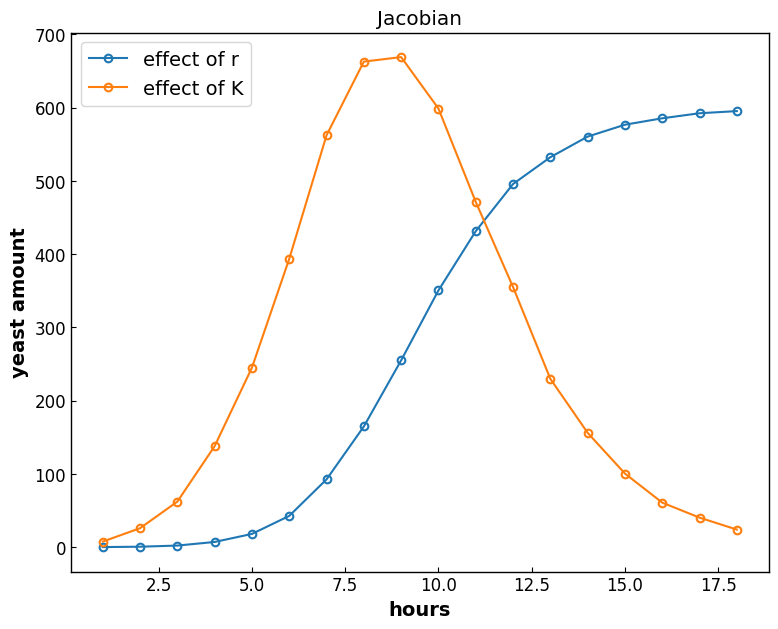

In [32]:
# Plot Jacobian
fig, ax = plt.subplots(1,1,figsize=(9,7))

ax.plot(time, np.abs(J[:,1]), '-o', linewidth=1.5, mfc='none', ms=5.5, mew=1.5, label='effect of r')
ax.plot(time, np.abs(J[:,0]), '-o', linewidth=1.5, mfc='none', ms=5.5, mew=1.5, label='effect of K')

# Set title, axes labels and legends
ax.set_title('Jacobian')
ax.set_xlabel('hours')
ax.set_ylabel('yeast amount')
ax.legend(loc='upper left')

plt.show()